In [ ]:
!pip install datasets==2.13.1
!pip install openai==0.27.8
!pip install evaluate==0.4.0
!pip install rouge_score==0.1.2
!pip install bert_score==0.3.13

!pip install langchain==0.0.229
!pip install unstructured==0.8.0
!pip install tiktoken==0.4.0

In [ ]:
import pandas as pd
from datasets import load_dataset
import evaluate
import openai

import numpy as np
import pprint

# Summarization using OpenAI API

In this notebook, we'll explore different approaches to text summarization using ChatGPT and cover following aspects:

1. Short text summarization:
  
    * Using prompt with unstable results    
    * Using prompt with stable results
    * Prompt Evaluation: evaluate stability of prompts
    * ML Evaluation: use BERT-score to evaluate quality of summarization

2. Long text summarization:
    * Map Reduce approach
    * Refine approach
    * Refine approach with custom promts

# 1. Short text summarization

Text summarization is the process of distilling the most important information from a text document into a shorter, more concise summary. It’s a useful technique for condensing large volumes of information into easily digestible formats, such as news articles, research papers, and business reports.

In this chapter we will use a few articles from CNN news dataset. We will take full article texts, get their summary
generated by unstable and stable promts and evaluate quality of summarization.  

First of all, we download the data.

In [ ]:
# Load train, validation, and test sets
dataset = load_dataset(path="ccdv/cnn_dailymail", name="3.0.0")

We need two columns from the dataset:
* article - full text of an article
* highlights - short summary of an article which we can use as a reference for summarization.

Let's take a look on a random article and its highlight:

In [ ]:
pprint.pprint(dataset['train']['article'][1])

('(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming '
 "his third gold in Moscow as he anchored Jamaica to victory in the men's "
 '4x100m relay. The fastest man in the world charged clear of United States '
 'rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar '
 'Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished '
 'second in 37.56 seconds with Canada taking the bronze after Britain were '
 'disqualified for a faulty handover. The 26-year-old Bolt has now collected '
 'eight gold medals at world championships, equaling the record held by '
 'American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention '
 'the small matter of six Olympic titles. The relay triumph followed '
 'individual successes in the 100 and 200 meters in the Russian capital. "I\'m '
 "proud of myself and I'll continue to work to dominate for as long as "
 'possible," Bolt said, having previously expressed his intention to carry on '


In [ ]:
pprint.pprint(dataset['train']['highlights'][1])

('Usain Bolt wins third gold of world championship .\n'
 'Anchors Jamaica to 4x100m relay victory .\n'
 'Eighth gold at the championships for Bolt .\n'
 "Jamaica double up in women's 4x100m relay .")


Now we take this one article and its highlight and will try diffrent promts on thise just one in the next chapter.



In [ ]:
example_text = dataset['train']['article'][1]
example_sum = dataset['train']['highlights'][1]

In [ ]:
# DON'T FORGET TO ADD API_KEY
OPENAI_API_KEY = "YOUR_API_KEY"
openai.api_key = OPENAI_API_KEY

## 1.1 Prompt with unstable results   

Unstable prompts refer to text inputs that produce unpredictable or unreliable outputs when interacting with language models like ChatGPT. It means that certain phrasings or formulations of prompts can lead to inconsistent or nonsensical responses(c)ChatGPT  
     
    
We will use ROUGE metric to evaluate stability.    
ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics commonly used for evaluating the quality of automatic summaries or machine-generated summaries compared to reference summaries. ROUGE measures the overlap between the generated summary and the reference summaries using various techniques.

In [ ]:
rouge = evaluate.load('rouge')

We create a function to call ChatGPT which take two parameters:   
1. prompts - a string with promt
2. temp - "temperature" is a parameter that controls the randomness of the model's responses. In this notebook we use value 0, but you can change this value and see how much more creative generated output will become.

In [ ]:
def call_gpt(prompts, temp=0):
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompts}],
        temperature=temp
        )
    return completion["choices"][0]["message"]["content"]

We start with creation a short vague promt, generate output twice with this promt and evaluate diffrence in outputs visually and using ROUGE metric.

We expect that outputs will be diffrent as the promt or instruction is not very clear

In [ ]:
unstable_promt_1 = f"""explain me this text
                   text: {example_text}
"""

unstable_promt_1_output_1 = call_gpt(unstable_promt_1)
unstable_promt_1_output_2 = call_gpt(unstable_promt_1)

pprint.pprint(unstable_promt_1_output_1)
pprint.pprint(unstable_promt_1_output_2)

print(rouge.compute(predictions=[unstable_promt_1_output_1], references=[unstable_promt_1_output_2]))

('This text is a news article reporting on the final day of the world '
 'championships in Moscow. It begins by stating that Usain Bolt won his third '
 "gold medal in the men's 4x100m relay, anchoring the Jamaican team to "
 'victory. The United States finished second and Canada took the bronze after '
 'Britain was disqualified. Bolt now has a total of eight gold medals at world '
 'championships, equaling the record held by Carl Lewis, Michael Johnson, and '
 'Allyson Felix. He has also won six Olympic titles. Bolt expressed his '
 'intention to continue competing until the 2016 Rio Olympics.\n'
 '\n'
 "The article also mentions that Jamaica's women won the 4x100m relay gold, "
 'with Shelly-Ann Fraser-Pryce anchoring the team. The United States initially '
 'finished in the bronze medal position but was promoted to silver after '
 'France was disqualified. The British team was promoted to the bronze medal '
 'position.\n'
 '\n'
 'In other events, Teddy Tamgho of France set a new re

We see that outputs are quite diffrent and ROUGE are low meaning the promt is not stable.



## 1.2 Prompt with stable results  
We use the same aproach to test stable promts.  

Here we give model more clear instructions. For ChatGPT instruction "summarize" is more clear then "explain".

In [ ]:
stable_promt_1 = f"summarize this text {example_text}"

stable_promt_1_output_1 = call_gpt(stable_promt_1)
stable_promt_1_output_2 = call_gpt(stable_promt_1)

pprint.pprint(stable_promt_1_output_1)
pprint.pprint(stable_promt_1_output_2)

print(rouge.compute(predictions=[stable_promt_1_output_1], references=[stable_promt_1_output_2]))

('Usain Bolt won his third gold medal at the world championships in Moscow, '
 "anchoring Jamaica to victory in the men's 4x100m relay. Bolt now has a total "
 'of eight gold medals at world championships, equaling the record held by '
 "Carl Lewis, Michael Johnson, and Allyson Felix. Jamaica's women also won "
 'gold in the 4x100m relay, with Shelly-Ann Fraser-Pryce anchoring the team to '
 'victory. In other events, Teddy Tamgho of France won gold in the triple '
 "jump, Christina Obergfoll of Germany won gold in the women's javelin, Asbel "
 "Kiprop of Kenya won gold in the men's 1500m, and Eunice Jepkoech Sum of "
 "Kenya won gold in the women's 800m. The championship was marred by poor "
 "attendance and controversy over Yelena Isinbayeva's support of Russia's new "
 'laws on non-traditional sexual relations.')
('Usain Bolt won his third gold medal at the world championships in Moscow, '
 "anchoring Jamaica to victory in the men's 4x100m relay. Bolt now has a total "
 'of eight go

We see that two outputs are identical.  
Let's make our promt more precise.

In [ ]:
stable_promt_1 = f"""summarize this text in four sentences.
Text : {example_text}
"""

stable_promt_1_output_1 = call_gpt(stable_promt_1)
stable_promt_1_output_2 = call_gpt(stable_promt_1)

pprint.pprint(stable_promt_1_output_1)
pprint.pprint(stable_promt_1_output_2)

print(rouge.compute(predictions=[stable_promt_1_output_1], references=[stable_promt_1_output_2]))

('Usain Bolt won his third gold medal at the world championships in Moscow, '
 "anchoring Jamaica to victory in the men's 4x100m relay. Bolt now has a total "
 'of eight gold medals at world championships, equaling the record held by '
 "American athletes Carl Lewis, Michael Johnson, and Allyson Felix. Jamaica's "
 'women also won the 4x100m relay gold, with Shelly-Ann Fraser-Pryce anchoring '
 'the team. The championships were marred by poor attendance and controversy '
 "surrounding Russian pole vaulter Yelena Isinbayeva's remarks in support of "
 "Russia's new laws on non-traditional sexual relations.")
('Usain Bolt won his third gold medal at the world championships in Moscow, '
 "anchoring Jamaica to victory in the men's 4x100m relay. Bolt now has a total "
 'of eight gold medals at world championships, equaling the record held by '
 "American athletes Carl Lewis, Michael Johnson, and Allyson Felix. Jamaica's "
 'women also won the 4x100m relay gold, with Shelly-Ann Fraser-Pryce a

Results are still quite stable however ROUGE is slightly lower

## 1.3 Prompt Evaluation: evaluate stability of prompt(s)

In previous sections we've tested promts on one article. Now we run the same approach on a bunch of articles.

In [ ]:
def bunch_rouge_evaluation(txt1, txt2):
    metric = rouge.compute(predictions=[txt1], references=[txt2])
    return metric['rouge1'], ['rouge1']

In [ ]:
example_text_10 = dataset['train']['article'][:10]
example_sum_10 = dataset['train']['highlights'][:10]

In [ ]:
def run_batch_summarization(promt_start, t=0):
    rouge1_lst = []
    rouge2_lst = []
    rougeL_lst = []
    rougeLsum = []

    output_lst = []

    for text in example_text_10:
        promt = promt_start + " " + text
        output1 = call_gpt(promt, t)
        output2 = call_gpt(promt, t)

        metric = rouge.compute(predictions=[output1], references=[output2])

        rouge1_lst.append(metric['rouge1'])
        rouge2_lst.append(metric['rouge2'])
        rougeL_lst.append(metric['rougeL'])
        rougeLsum.append(metric['rougeLsum'])

        output_lst.append(output1)

    print("Mean rouge1:", np.mean(rouge1_lst))
    print("Mean rouge2:", np.mean(rouge2_lst))
    print("Mean rougeL:", np.mean(rougeL_lst))
    print("Mean rougeLsum:", np.mean(rougeLsum))

    return output_lst

Results for the unstable promt

In [ ]:
promt_start = "explain me this text: "

output_unstable_lst = run_batch_summarization(promt_start)

Mean rouge1: 0.8976697028824475
Mean rouge2: 0.8326181025281351
Mean rougeL: 0.8589133852615868
Mean rougeLsum: 0.8644360677073462


Results for the stable promt

In [ ]:
promt_start = "summarize this text in four sentences: "

output_stable_lst = run_batch_summarization(promt_start)

Mean rouge1: 0.9550915503033478
Mean rouge2: 0.9246966983036906
Mean rougeL: 0.9427219073102748
Mean rougeLsum: 0.9427219073102748


## 1.4 ML Evaluation: use DS/ML metrics (aka BERT-score)  

Here we will evaluate how "close" ChatGPT summarization from the previous step is to the original highlights. In order to do that we use BERTScore.

   BERTScore is a metric used for evaluating the quality of machine-generated text, particularly in the context of text generation tasks like machine translation or summarization. It measures the similarity between a generated text and one or more reference texts based on contextualized embeddings from the BERT (Bidirectional Encoder Representations from Transformers) model.

In [ ]:
bertscore = evaluate.load("bertscore")

In [ ]:
bert_score_stable = bertscore.compute(predictions=output_unstable_lst, references=example_sum_10, lang="en")
bert_score_unstable = bertscore.compute(predictions=output_stable_lst, references=example_sum_10, lang="en")


In [ ]:
print("Stable promt: ")
print("Mean precision:", np.mean(bert_score_stable['precision']))
print("Mean recall:", np.mean(bert_score_stable['recall']))
print("Mean f1:", np.mean(bert_score_stable['f1']))
print()
print("Unstable promt: ")
print("Mean precision:", np.mean(bert_score_unstable['precision']))
print("Mean recall:", np.mean(bert_score_unstable['recall']))
print("Mean f1:", np.mean(bert_score_unstable['f1']))

Stable promt: 
Mean precision: 0.8305123567581176
Mean recall: 0.8757950246334076
Mean f1: 0.8524613559246064

Unstable promt: 
Mean precision: 0.869539326429367
Mean recall: 0.8850488543510437
Mean f1: 0.8770989775657654


We see that both stable and unstable promts are good in summarization

## Conclusion
We tested stable and unstable promts, evaluated quality of overall summarization. We've seen that both stable and unstable promts are good in summarization.

Stability in the prompt is often desired when seeking reliable and accurate responses, especially in tasks where consistency and precision are important.

However, it's worth noting that excessive stability can limit the model's creativity and exploration. Finding the right balance between stability and variability is crucial in achieving the desired conversational experience.

# 2. Long text summarization
In this section we will explore how to summarize long texts.

ChatGPT has a token limit of approximately 4000 tokens per request. While it is possible to increase this limit, it comes with a substantial cost.
That is why we need to do some additional work to summarize long texts.

We will take the 1st Chapter of The Lord of The Rings by J.J.Tolkien and use a few approaches for summarization:

1. Map reduce approach
2. Refine approach




In [ ]:
from langchain.document_loaders import UnstructuredFileLoader
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate

from langchain import OpenAI

We read two files:  
* lotr_short_text.txt - text containing small part of the chapter
* lotr_long_text.txt - full text of the chapter

In [ ]:
small_loader = UnstructuredFileLoader("lotr_short_text.txt")
small_doc = small_loader.load()

large_loader = UnstructuredFileLoader("lotr_long_text.txt")
large_doc = large_loader.load()

This function helps us get information about our documents:

In [ ]:
def doc_summary(docs):
    print (f'You have {len(docs)} document(s)')

    num_words = sum([len(doc.page_content.split(' ')) for doc in docs])

    print (f'You have roughly {num_words} words in your docs')
    print ()
    pprint.pprint (f'Preview: \n{docs[0].page_content.split(". ")[:3]}')

In [ ]:
doc_summary(small_doc)

You have 1 document(s)
You have roughly 466 words in your docs

('Preview: \n'
 "['When Mr', 'Bilbo Baggins of Bag End announced that he would shortly be "
 'celebrating his eleventy-first birthday with a party of special '
 "magnificence, there was much talk and excitement in Hobbiton', 'Bilbo was "
 'very rich and very peculiar, and had been the wonder of the Shire for sixty '
 "years, ever since his remarkable disappearance and unexpected return']")


In [ ]:
doc_summary(large_doc)

You have 1 document(s)
You have roughly 9942 words in your docs

('Preview: \n'
 "['When Mr', 'Bilbo Baggins of Bag End announced that he would shortly be "
 'celebrating his eleventy-first birthday with a party of special '
 "magnificence, there was much talk and excitement in Hobbiton', 'Bilbo was "
 'very rich and very peculiar, and had been the wonder of the Shire for sixty '
 "years, ever since his remarkable disappearance and unexpected return']")


In [ ]:
llm = OpenAI(openai_api_key=OPENAI_API_KEY)

For the short text summarization(number of tokens less then 4000) we can use load_summarize_chain from langchain.chains.summarize
with parameter **chain_type="stuff"**.

We also use verbose=True to see what promt is generated and used for the task

In [ ]:
chain = load_summarize_chain(llm, chain_type="stuff", verbose=True)

In [ ]:
chain.run(small_doc)



> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
Write a concise summary of the following:


"When Mr. Bilbo Baggins of Bag End announced that he would shortly be celebrating his eleventy-first birthday with a party of special magnificence, there was much talk and excitement in Hobbiton. Bilbo was very rich and very peculiar, and had been the wonder of the Shire for sixty years, ever since his remarkable disappearance and unexpected return. The riches he had brought back from his travels had now become a local legend, and it was popularly believed, whatever the old folk might say, that the Hill at Bag End was full of tunnels stuffed with treasure. And if that was not enough for fame, there was also his prolonged vigour to marvel at. Time wore on, but it seemed to have little effect on Mr. Baggins. At ninety he was much the same as at fifty. At ninety-nine they began to call him well-preserved; but unchanged would have been nearer the mark. There were some 

' Bilbo Baggins of Bag End was a wealthy and peculiar hobbit who was famous in the Shire for his travels and his longevity. He was generous to many hobbits and adopted his favorite cousin, Frodo Baggins, as his heir. When Bilbo and Frodo both turned 111 and 33 respectively, they planned a combined birthday party of special magnificence, and rumors of the event spread throughout the Shire.'

However if you try this approach on the full text you get an error.
If you run next cell, you will get:  
*InvalidRequestError: This model's maximum context length is 4097 tokens, however you requested 14394 tokens (14138 in your prompt; 256 for the completion). Please reduce your prompt; or completion length.*

In [ ]:
chain.run(large_doc)

## 2.1 Summarize: Map Reduce

The first approach for documents that are over the limit, is map-reduce: we split the document into smaller sections or summaries to consolidate as a summary that can fit into the 4K token limit.

Map reduce is a paradigm where you map, shuffle, and reduce to fit as useful data to the model.


Pros:   
*   scales to larger documents   

*   can also be parallelized

Cons:
*   creates quite a few API calls
*   is prone to loss of information as we are contexting the summary as opposed to the original document.

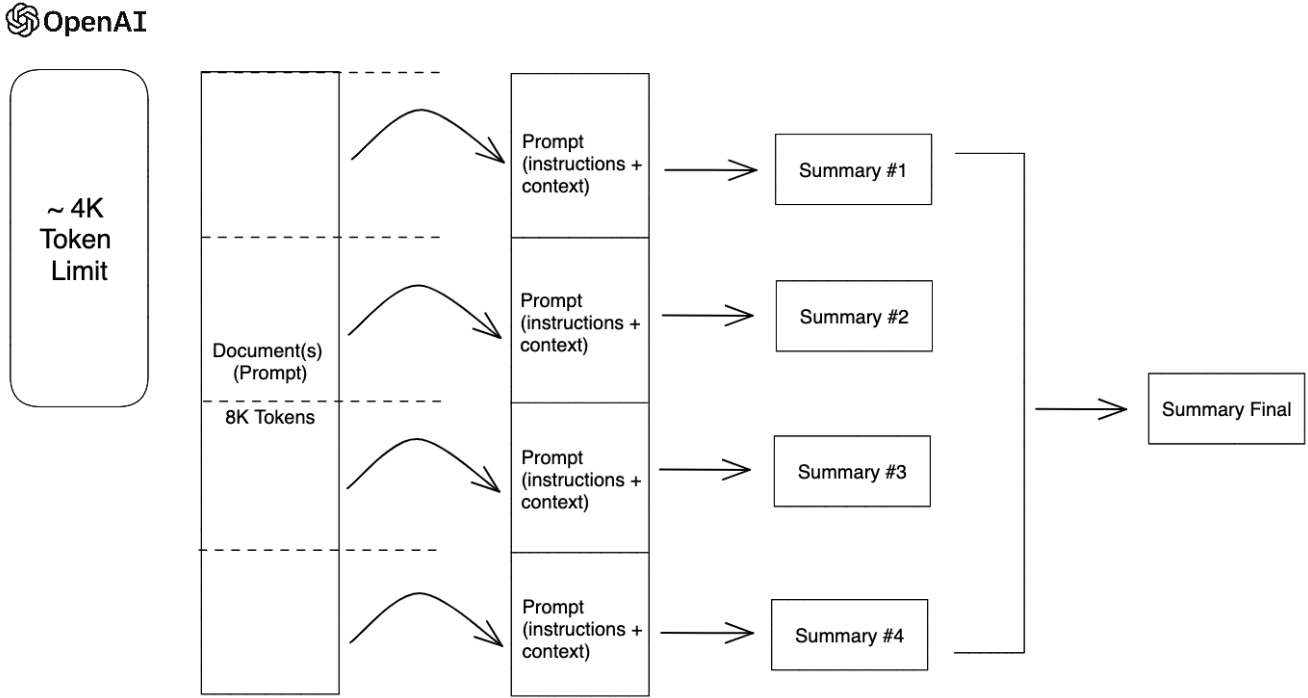

We need to split a long text in shorter chunks:

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 0
)

In [ ]:
lg_docs = text_splitter.split_documents(large_doc)

Let's take a look on a result of slpitting

In [ ]:
doc_summary(lg_docs)

You have 77 document(s)
You have roughly 9980 words in your docs

('Preview: \n'
 "['When Mr', 'Bilbo Baggins of Bag End announced that he would shortly be "
 'celebrating his eleventy-first birthday with a party of special '
 "magnificence, there was much talk and excitement in Hobbiton', 'Bilbo was "
 'very rich and very peculiar, and had been the wonder of the Shire for sixty '
 "years, ever since his remarkable disappearance and unexpected return']")


Also for map reduce approach we change the parameter:  
*chain_type="map_reduce"*

In [ ]:
chain = load_summarize_chain(llm, chain_type="map_reduce", verbose=True)

Now let's run summarization on the first 3 chunks to see how promts change

In [ ]:
chain.run(lg_docs[:3])



> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
Write a concise summary of the following:


"When Mr. Bilbo Baggins of Bag End announced that he would shortly be celebrating his eleventy-first birthday with a party of special magnificence, there was much talk and excitement in Hobbiton. Bilbo was very rich and very peculiar, and had been the wonder of the Shire for sixty years, ever since his remarkable disappearance and unexpected return. The riches he had brought back from his travels had now become a local legend, and it was popularly believed, whatever the old folk might say, that the Hill at Bag End was full of tunnels stuffed with treasure. And if that was not enough for fame, there was also his prolonged vigour to marvel at. Time wore on, but it seemed to have little effect on Mr. Baggins. At ninety he was much the same as at fifty. At ninety-nine they began to call him well-preserved; but unchanged would have been nearer the mark. There were some 

'\nBilbo Baggins is a local legend of Hobbiton due to his remarkable disappearance and unexpected return with riches, and his prolonged vigour from 50 to 99 years old. Despite warnings of trouble, no trouble has come and he is generous with his money, allowing him to stay on friendly terms with his relatives and be popular with other hobbits. He adopted his favorite cousin, Frodo Baggins, as his heir when he was 99 and the two celebrate their combined birthday parties every year. This year, Bilbo is turning 111 and the party is planned to be exceptional.'

Run on the full set of documents

In [ ]:
chain = load_summarize_chain(llm, chain_type="map_reduce")
final_summary_mapreduce = chain.run(lg_docs)

Result of summarization of the full novel chapter:

In [ ]:
pprint.pprint(final_summary_mapreduce)

('\n'
 '\n'
 'Mr. Bilbo Baggins of Bag End became famous in the Shire for his remarkable '
 'disappearance and return, as well as the wealth he brought back from his '
 'travels. He was known for his prolonged vigour and lack of aging, which '
 'caused some to shake their heads in disapproval. He was allegedly blessed '
 'with perpetual youth and inexhaustible wealth, leading some to speculate '
 'about the cost of his good fortune. Despite this, Mr. Baggins remained in '
 'good standing with his relatives, excluding the Sackville-Bagginses, who had '
 'expected to inherit Bag End when he was thought to be dead. He had no close '
 'friends until some of his younger cousins began to grow up, and among them, '
 'his favorite was young Frodo Baggins, who was his second cousin. When Bilbo '
 'was ninety-nine, he adopted Frodo as his heir, and brought him to live at '
 "Brandy Hall among his many relatives. Tragically, Frodo's parents, Mr. Drogo "
 'and his wife, were drowned in a boating a

## 2.2 Summarize: Refine

Another approach is refine. The idea of refining is that you send multiple prompts to OpenAI's ChatGPT to refine its context prior to composing a final summary that will then be used to prime the conversation for the response.

Pros:
*  more relevant context.   

Cons:
*  more independent API calls to OpenAI.

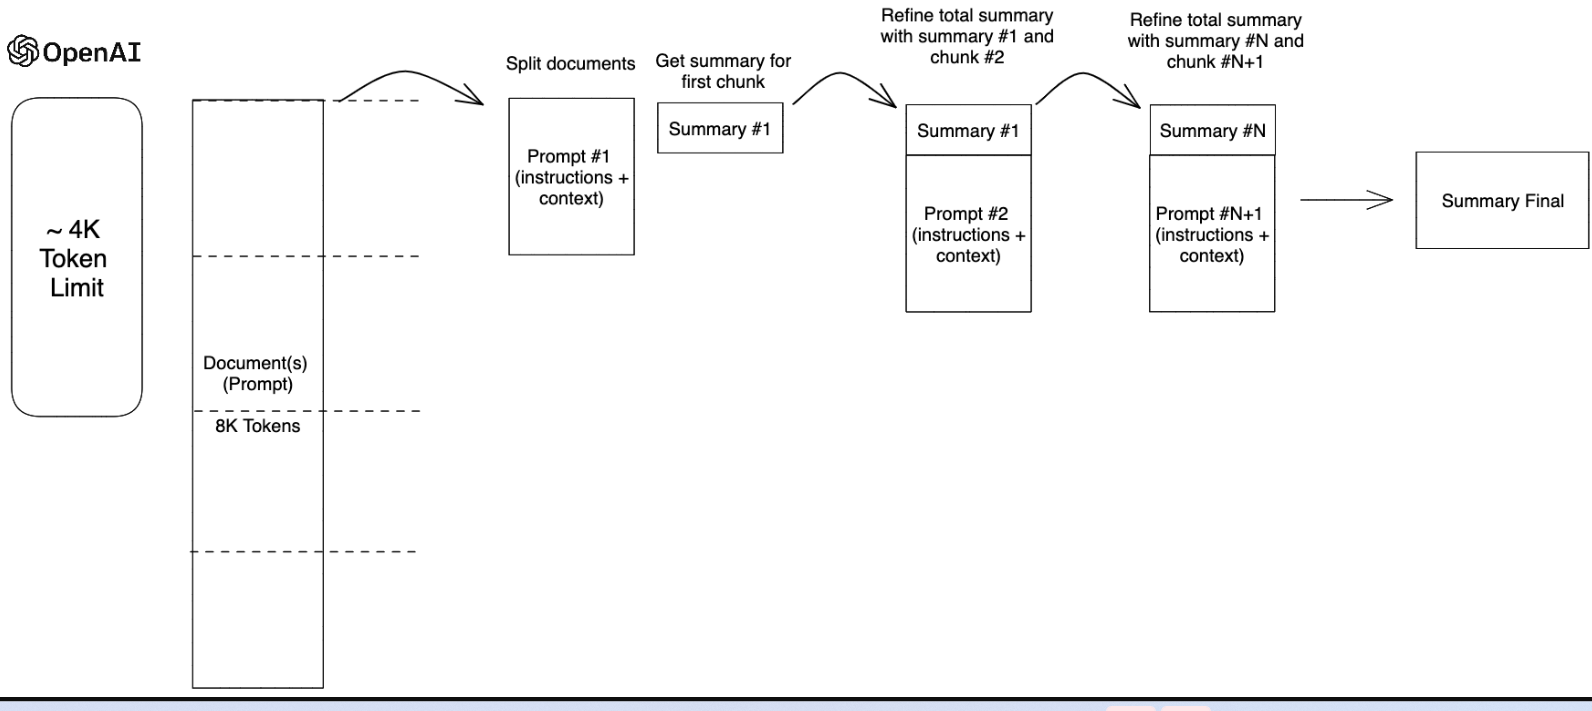


In [ ]:
chain = load_summarize_chain(llm, chain_type="refine", verbose=True)

Now let's run summarization on the first 3 chunks to see how promts are changing

In [ ]:
chain.run(lg_docs[:3])



> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
Write a concise summary of the following:


"When Mr. Bilbo Baggins of Bag End announced that he would shortly be celebrating his eleventy-first birthday with a party of special magnificence, there was much talk and excitement in Hobbiton. Bilbo was very rich and very peculiar, and had been the wonder of the Shire for sixty years, ever since his remarkable disappearance and unexpected return. The riches he had brought back from his travels had now become a local legend, and it was popularly believed, whatever the old folk might say, that the Hill at Bag End was full of tunnels stuffed with treasure. And if that was not enough for fame, there was also his prolonged vigour to marvel at. Time wore on, but it seemed to have little effect on Mr. Baggins. At ninety he was much the same as at fifty. At ninety-nine they began to call him well-preserved; but unchanged would have been nearer the mark. There were some 

"\n\nMr. Bilbo Baggins of Bag End had become a local legend of the Shire for sixty years due to his remarkable disappearance and unexpected return, bringing back riches that were now a local legend, as well as apparently perpetual youth and reputedly inexhaustible wealth. Despite the suspicion of some people, Mr. Baggins was generous with his money and had many devoted admirers among the hobbits of poor and unimportant families. He had no close friends until some of his younger cousins, such as Frodo, began to grow up. Frodo was adopted as Bilbo's heir, and they shared the same birthday, September 22nd. After twelve more years, Bilbo was to celebrate his eleventy-first birthday with a party of special magnificence."

Run full text

In [ ]:
chain = load_summarize_chain(llm, chain_type="refine")
final_summary_refine = chain.run(lg_docs)

In [ ]:
print("Refine full output: ")
pprint.pprint(final_summary_refine)


Refine full output: 
('\n'
 '\n'
 'Mr. Bilbo Baggins of Bag End was celebrated for his eleventy-first birthday '
 'with a party, an age considered remarkable for a hobbit. He was known '
 'throughout the Shire for his mysterious disappearance and return with '
 'riches, his tunnels full of treasure, his prolonged vigour and (apparently) '
 'perpetual youth, as well as (reputedly) inexhaustible wealth. Though some '
 'thought it was unfair for him to possess such luck, he was generous with his '
 'money, gaining the forgiveness of many, and he had many admirers among the '
 'poorer hobbits. He had no close friends until his younger cousins, Drogo and '
 'Frodo Baggins, began to grow up. His favorite was Frodo, and when Bilbo was '
 'ninety-nine, he adopted Frodo as his heir and brought him to live at Bag '
 'End, much to the disappointment of the Sackville-Bagginses that had expected '
 'to inherit Bag End. They shared the same birthday, September 22nd, and each '
 'year the Bagginses h

Compare with map reduce result:

In [ ]:
print("Mapreduce full output: ")
pprint.pprint(final_summary_mapreduce)

Mapreduce full output: 
('\n'
 '\n'
 'Mr. Bilbo Baggins of Bag End became famous in the Shire for his remarkable '
 'disappearance and return, as well as the wealth he brought back from his '
 'travels. He was known for his prolonged vigour and lack of aging, which '
 'caused some to shake their heads in disapproval. He was allegedly blessed '
 'with perpetual youth and inexhaustible wealth, leading some to speculate '
 'about the cost of his good fortune. Despite this, Mr. Baggins remained in '
 'good standing with his relatives, excluding the Sackville-Bagginses, who had '
 'expected to inherit Bag End when he was thought to be dead. He had no close '
 'friends until some of his younger cousins began to grow up, and among them, '
 'his favorite was young Frodo Baggins, who was his second cousin. When Bilbo '
 'was ninety-nine, he adopted Frodo as his heir, and brought him to live at '
 "Brandy Hall among his many relatives. Tragically, Frodo's parents, Mr. Drogo "
 'and his wife, wer

We can see that the refine summarization and map reduce outputs are different. It's hard to determine which result is better, but it seems like the map reduce output includes more unimportant details, while the refine output provides a more general overview.


## 2.3 Summarize: Refine with custom promts

we have seen good quality summarization but if we want to create a summary with focus on some details we can create custom promts. Custom promts can be created for both map reduce and refine but we test just refine approach.

In this section we create promt to get data mainly about one character from the novel, Frodo.

We need to create two custom promts:  
1. prompt_template - start generation with this promt
2. refine_template - continue generation with this promt and output from the previous step

In [ ]:
prompt_template = """Write a concise summary of the following:


{text}


CONCISE SUMMARY ABOUT FRODO AND HIS LIFE:"""
PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])

refine_template = (
    "Your job is to produce a final summary just about Frodo and his life\n"
    "We have provided an existing summary up to a certain point: {existing_answer}\n"
    "We have the opportunity to refine the existing summary"
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{text}\n"
    "------------\n"
    "Given the new context, refine the original summary just about Frodo and his life"
    "If the context isn't useful, return the original summary."
)
refine_prompt = PromptTemplate(
    input_variables=["existing_answer", "text"],
    template=refine_template,
)

chain = load_summarize_chain(llm, chain_type="refine",
                             question_prompt=PROMPT,
                             refine_prompt=refine_prompt,
                             verbose = False)


In [ ]:
final_summary_refine_custom = chain({"input_documents": lg_docs}, return_only_outputs=True)

We can see that this promt works great and we've got much more information about Frodo.

In [ ]:
pprint.pprint(final_summary_refine_custom['output_text'])

('\n'
 '\n'
 'Frodo Baggins was the adopted heir of Bilbo Baggins, his favorite amongst '
 'his younger cousins. At the age of 99, Bilbo brought Frodo to live at Bag '
 'End and they celebrated their shared birthday together with a selection of '
 'guests from their related families, as well as some special unrelated '
 'friends. Bilbo showed his immense love for Frodo by presenting him with a '
 'short sword, his personal possession, and by standing up to the intimidating '
 'figure of Gandalf the Grey. He also entrusted Frodo with the One Ring as '
 'well as his will and other documents, demonstrating his deep commitment to '
 'Frodo and his desire to ensure his safety. On their last night together, '
 'Bilbo gave Frodo a parting gift of spoons, showing his appreciation for the '
 'beloved adoptive son he had come to love. Frodo also displayed politeness '
 'and firmness towards Lobelia Sackville-Baggins, despite her rather offensive '
 'demeanor, and Gandalf later gave him a warning

## Conclusion  

We've tried out both map reduce and refine methods for summarizing long texts. We've noticed that the results are different. However if we want the summary to highlight specific details, we can create custom prompts to achieve that.

## References
More about text summarization with langchain:  
https://docs.langchain.com/docs/use-cases/summarization